In [12]:
import pickle
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_pkl(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

# Process data

In [3]:
from components.DataProcessor import DataProcessor


file_path = 'COMP90086_2023_TLLdataset/train.csv'
test_file_path = 'COMP90086_2023_TLLdataset/test_candidates.csv'
save_path = 'dictionaries'
dataset_base_path = 'COMP90086_2023_TLLdataset'

processor = DataProcessor(file_path, test_file_path, save_path, dataset_base_path)
processor.load_data()
processor.split_data()
processor.generate_dictionaries()
processor.save_dictionaries()
processor.process_test_candidates()

Dictionaries saved to 'dictionaries/train_dict.pkl' and 'dictionaries/val_dict.pkl'
Dictionaries saved to dictionaries/test_dict.pkl


In [3]:
train_data = load_pkl('dictionaries/train_dict.pkl')
val_data = load_pkl('dictionaries/val_dict.pkl')
test_data = load_pkl('dictionaries/test_dict.pkl')

print('train data size: ', len(train_data))
print('val data size: ', len(val_data))
print('test data size: ', len(test_data))

train data size:  1600
val data size:  400
test data size:  2000


In [5]:
# print('train data sample: ', val_data)

# Extract features

In [5]:
from components.FeatureExtractor import FeatureExtractor

# define the output dir & models you want to train here
base_output_dir = "feat"
models_to_train = ["resnet50", "resnet101", "resnet152", "densenet201", "vgg16", "mobilenet", "EfficientNetB0", "mobilenetv2"]

train_data = load_pkl('dictionaries/train_dict.pkl')
val_data = load_pkl('dictionaries/val_dict.pkl')
test_data = load_pkl('dictionaries/test_dict.pkl')

for model_name in models_to_train:
    extractor = FeatureExtractor(model_name, base_output_dir)
    for set_name, data_dict in [("train_data", train_data), ("val_data", val_data)]:
        extractor.extract_and_save_features(data_dict, set_name)

# extractor = FeatureExtractor("resnet18", base_output_dir)
# for set_name, data_dict in [("train_data", train_data), ("val_data", val_data)]:
#     extractor.extract_and_save_features(data_dict, set_name)

# model_name = "mobilenet"
# extractor = FeatureExtractor(model_name, base_output_dir)
# extractor.extract_and_save_features_for_test(test_data, "test_data")

1/1 [==============================] - 0s 20ms/step


# Accuracy

In [17]:
from components.SimilarityEvaluator import SimilarityEvaluator

with open("dictionaries/val_dict.pkl", 'rb') as f:
    val_dict = pickle.load(f)

model_names = ["resnet50", "resnet101", "resnet152", "densenet201", "vgg16", "mobilenet", "EfficientNetB0", "mobilenetv2"]
metrics = ["cosine", "euclidean", "manhattan"]

result = {}

for model_name in model_names:
    for metric in metrics:
        evaluator = SimilarityEvaluator(model_name, "val_data", "feat", metric)
        # evaluator.evaluate_accuracy(val_dict, "val_data")
        
        result[(model_name, metric)] = evaluator.evaluate_accuracy(val_dict)

df = pd.DataFrame(list(result.items()), columns=["Model & distance", "Accuracy"])
print(df)

               Model & distance  Accuracy
0            (resnet50, cosine)    0.4525
1         (resnet50, euclidean)    0.0300
2         (resnet50, manhattan)    0.0250
3           (resnet101, cosine)    0.4350
4        (resnet101, euclidean)    0.0375
5        (resnet101, manhattan)    0.0375
6           (resnet152, cosine)    0.4525
7        (resnet152, euclidean)    0.0525
8        (resnet152, manhattan)    0.0475
9         (densenet201, cosine)    0.4875
10     (densenet201, euclidean)    0.0250
11     (densenet201, manhattan)    0.0325
12              (vgg16, cosine)    0.4450
13           (vgg16, euclidean)    0.0500
14           (vgg16, manhattan)    0.0475
15          (mobilenet, cosine)    0.5025
16       (mobilenet, euclidean)    0.0300
17       (mobilenet, manhattan)    0.0225
18     (EfficientNetB0, cosine)    0.4450
19  (EfficientNetB0, euclidean)    0.0375
20  (EfficientNetB0, manhattan)    0.0425
21        (mobilenetv2, cosine)    0.3400
22     (mobilenetv2, euclidean)   

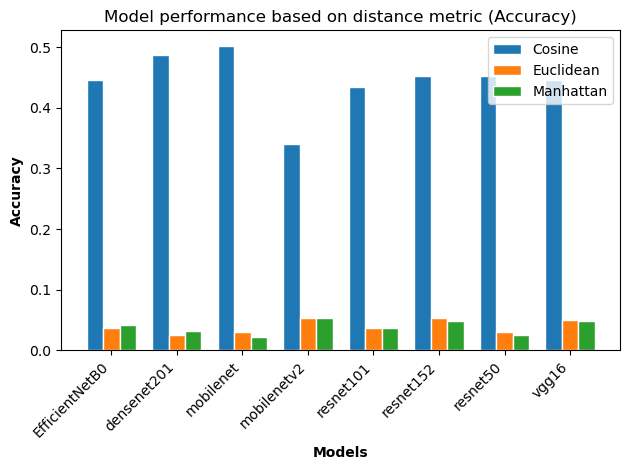

In [18]:
df[['Model', 'Distance']] = pd.DataFrame(df['Model & distance'].tolist(), index=df.index)
df.drop('Model & distance', axis=1, inplace=True)

# Pivot the dataframe for plotting
plot_df = df.pivot(index='Model', columns='Distance', values='Accuracy')

# Define the data
models = plot_df.index.tolist()
cosine = plot_df['cosine'].tolist()
euclidean = plot_df['euclidean'].tolist()
manhattan = plot_df['manhattan'].tolist()

barWidth = 0.25
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create bars
plt.bar(r1, cosine, width=barWidth, edgecolor='white', label='Cosine')
plt.bar(r2, euclidean, width=barWidth, edgecolor='white', label='Euclidean')
plt.bar(r3, manhattan, width=barWidth, edgecolor='white', label='Manhattan')

# Title & Subtitle
plt.title("Model performance based on distance metric (Accuracy)")
plt.xlabel("Models", fontweight='bold')
plt.ylabel("Accuracy", fontweight='bold')
plt.xticks([r + barWidth for r in range(len(cosine))], models, rotation=45, ha='right')

# Create legend & Show graphic
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("model_performance_plot.png", dpi=300)
plt.show()

# Get predictions and export to scv file

In [17]:
import os
import csv
import numpy as np

def compute_similarity(vec1, vec2, metric='cosine'):
    """Compute similarity between two vectors."""
    # Flatten the vectors
    vec1_flat = vec1.flatten()
    vec2_flat = vec2.flatten()

    if metric == 'cosine':
        dot_product = np.dot(vec1_flat, vec2_flat)
        norm_a = np.linalg.norm(vec1_flat)
        norm_b = np.linalg.norm(vec2_flat)
        similarity = dot_product / (norm_a * norm_b)
    else:
        raise ValueError(f"Unsupported metric: {metric}")
    
    return similarity

# Load features
def load_saved_features(model_name, set_name, side, base_dir="feat"):
    features_file_path = os.path.join(base_dir, model_name, set_name, f"{set_name}_{side}_features.pkl")
    with open(features_file_path, 'rb') as f:
        features_dict = pickle.load(f)
    return features_dict

# Create a dictionary to store similarity scores
similarity_scores = {}

# Load the saved features for mobileNet
test_left = load_saved_features("mobileNet", "test_data", "left")
test_right = load_saved_features("mobileNet", "test_data", "right")

# Iterate through the rows of the CSV file
with open('COMP90086_2023_TLLdataset/test_candidates.csv', 'r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        left_image = row['left']
        right_images = [row[f'c{i}'] for i in range(20)]
        
        scores = []  # List to store similarity scores for the current left image
        
        # Iterate through the right images
        for right_image in right_images:
            left_image_path = os.path.join('COMP90086_2023_TLLdataset/test/left', left_image)
            right_image_path = os.path.join('COMP90086_2023_TLLdataset/test/right', right_image)
            
            left_features = test_left[left_image_path + '.jpg']
            right_features = test_right[right_image_path + '.jpg']
            
            # Compute the similarity between the left and right images
            similarity = compute_similarity(left_features, right_features)
            scores.append(similarity)
        
        # Add the scores to the dictionary with the left image as the key
        similarity_scores[left_image] = scores

# Write the similarity scores to a new CSV file
with open('similarity_scores.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header row
    header_row = ['left'] + [f'c{i}' for i in range(20)]
    writer.writerow(header_row)

    # Write the similarity scores for each left image
    for left_img, scores in similarity_scores.items():
        writer.writerow([left_img] + scores)
